In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 8
commitnumber = 5014a19
conc = None
dv = 0.01
klin = 0
molecule = h2o
ng_adju = [0, -1, 0]
ng_refs = [3, 2, 3]
nv = 100
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 1900
vmin = 1380
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66), (1.66, 1.66, 1.66)]
wgt = [(0.55, 0.55, 0.85), (0.85, 0.85), (0, 0.3, 0.55)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

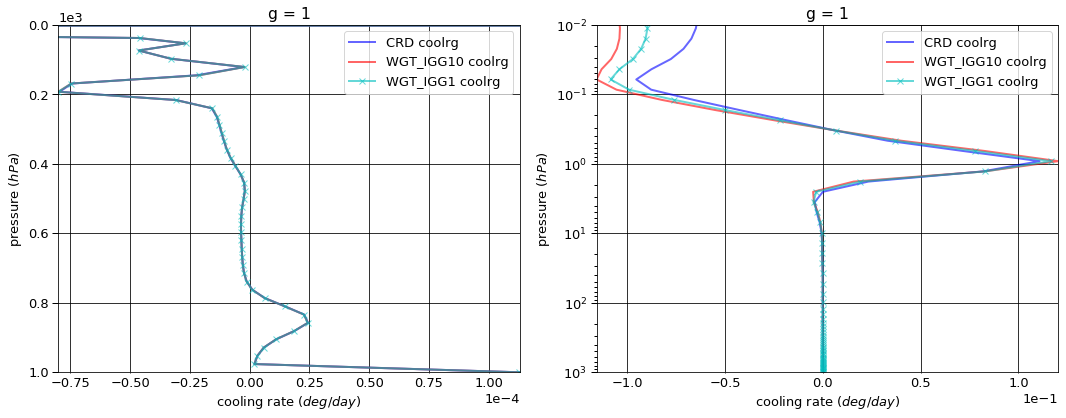

# Figure: cooling rate g-group 2

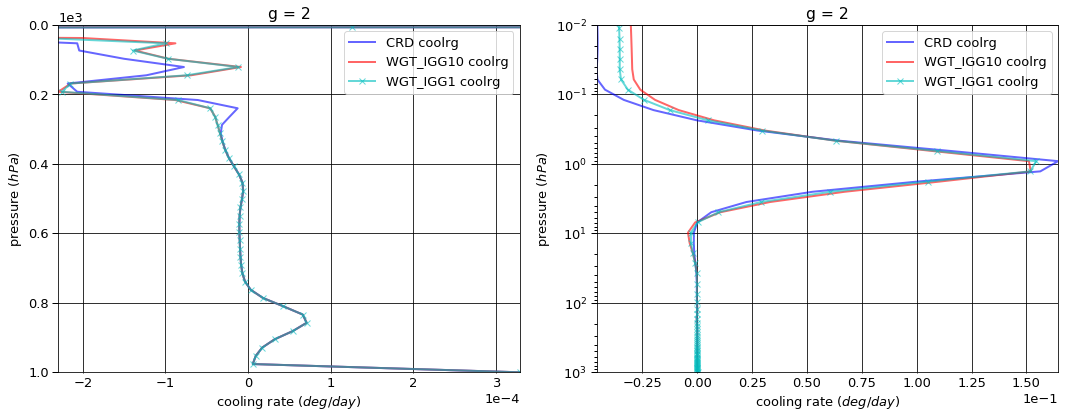

# Figure: cooling rate g-group 3

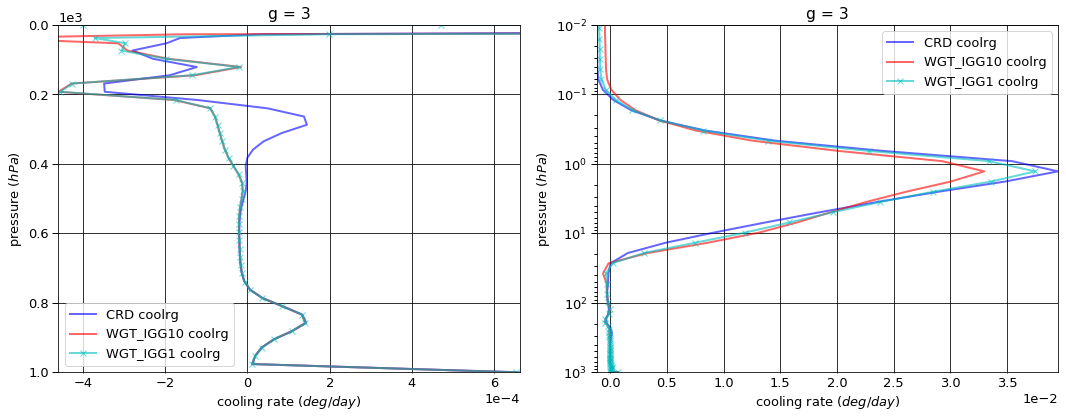

# Figure: cooling rate g-group 4

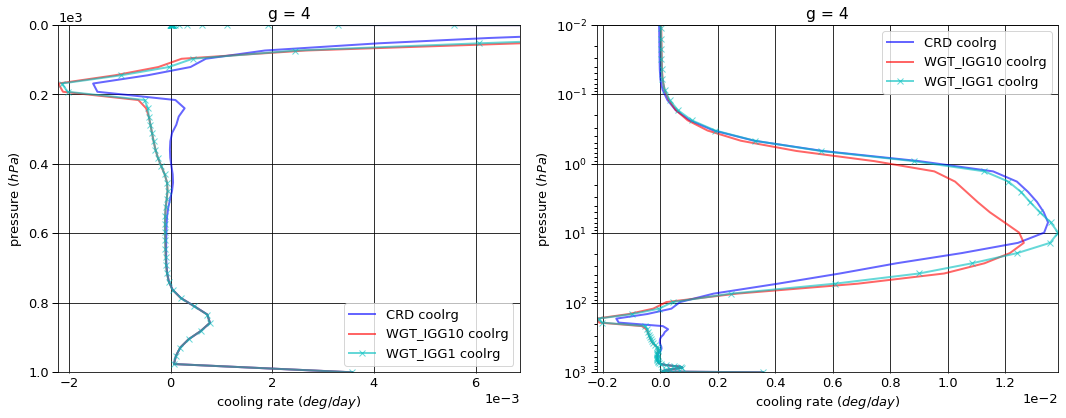

# Figure: cooling rate g-group 5

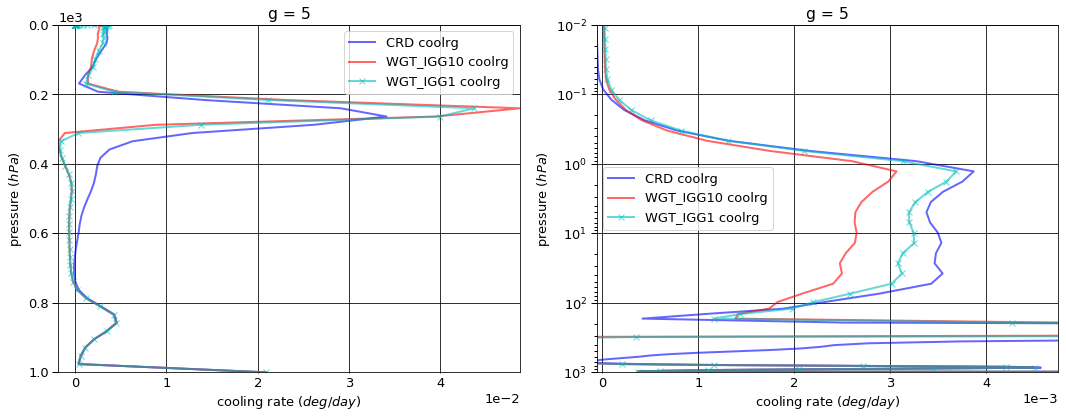

# Figure: cooling rate g-group 6

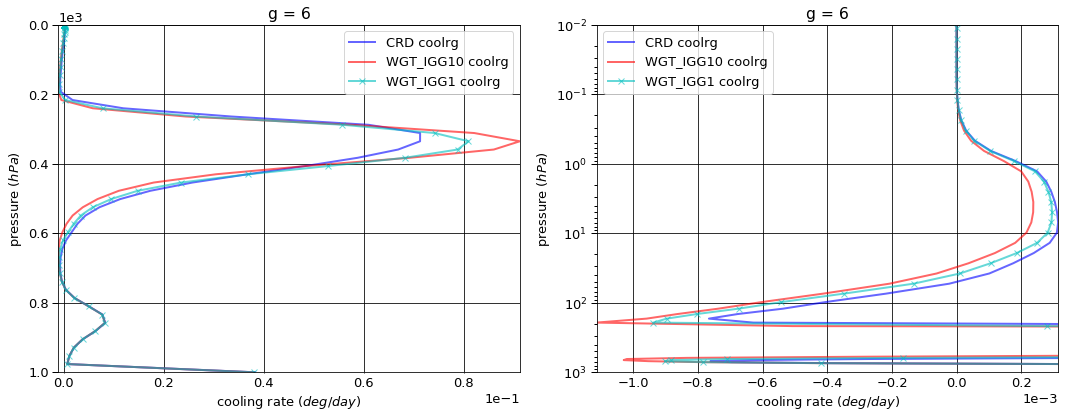

# Figure: cooling rate g-group 7

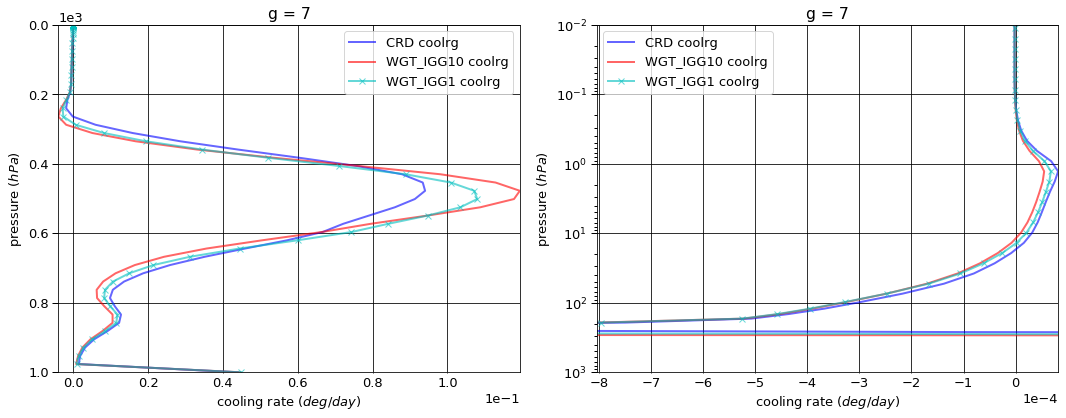

# Figure: cooling rate g-group 8

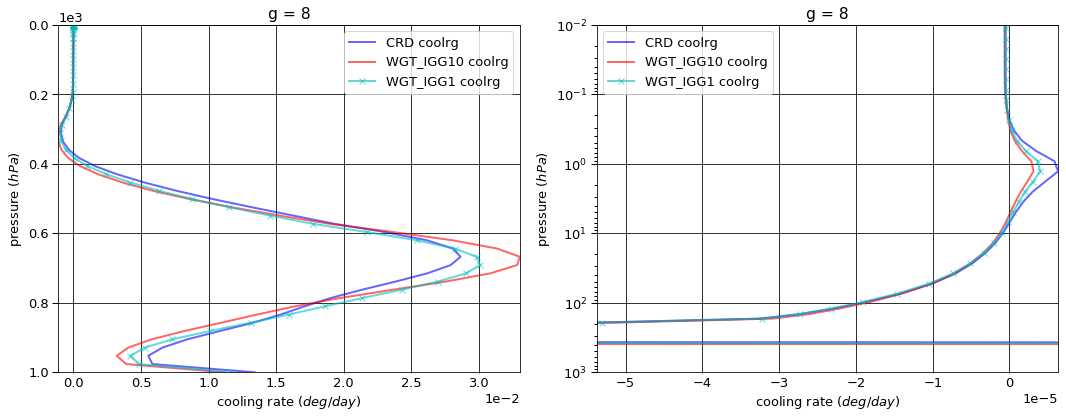

# Figure: cooling rate g-group total

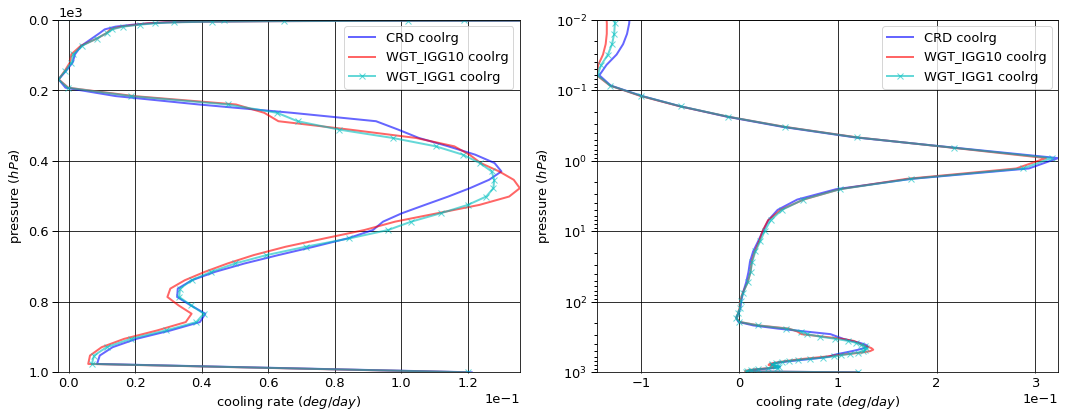

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.007768   0.000000 -0.007768
  1013.0   76     -0.029748   0.029429 -0.000318
2 0.0      1      -0.029024   0.000000 -0.029024
  1013.0   76     -0.086531   0.085606 -0.000925
3 0.0      1      -0.028928   0.000000 -0.028928
  1013.0   76     -0.173295   0.171430 -0.001866
4 0.0      1      -0.086966   0.000000 -0.086966
  1013.0   76     -0.940384   0.930323 -0.010061
5 0.0      1      -0.632575   0.000000 -0.632575
  1013.0   76     -5.492048   5.433272 -0.058776
6 0.0      1      -1.802397   0.000000 -1.802397
  1013.0   76    -10.051258   9.943421 -0.107837
7 0.0      1      -3.542884   0.000000 -3.542884
  1013.0   76    -11.570812  11.446529 -0.124283
8 0.0      1      -1.162481   0.000000 -1.162481
  1013.0   76     -2.385540   2.332391 -0.053150


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.007246   0.000000 -0.007246
  1013.0   76     -0.029677   0.029360 -0.000318
2 0.0      1      -0.031101   0.000000 -0.031101
  1013.0   76     -0.086607   0.085680 -0.000927
3 0.0      1      -0.029086   0.000000 -0.029086
  1013.0   76     -0.171646   0.169808 -0.001838
4 0.0      1      -0.081220   0.000000 -0.081220
  1013.0   76     -0.939113   0.929057 -0.010056
5 0.0      1      -0.527688   0.000000 -0.527688
  1013.0   76     -5.491339   5.432536 -0.058803
6 0.0      1      -1.800466   0.000000 -1.800466
  1013.0   76    -10.004601   9.897468 -0.107133
7 0.0      1      -3.558861   0.000000 -3.558861
  1013.0   76    -11.746879  11.621058 -0.125821
8 0.0      1      -1.131407   0.000000 -1.131407
  1013.0   76     -2.259754   2.223203 -0.036551


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.007409   0.000000 -0.007409
  1013.0   76     -0.029677   0.029360 -0.000318
2 0.0      1      -0.030270   0.000000 -0.030270
  1013.0   76     -0.086607   0.085680 -0.000927
3 0.0      1      -0.029483   0.000000 -0.029483
  1013.0   76     -0.171646   0.169808 -0.001838
4 0.0      1      -0.082389   0.000000 -0.082389
  1013.0   76     -0.939113   0.929057 -0.010056
5 0.0      1      -0.533982   0.000000 -0.533982
  1013.0   76     -5.491339   5.432536 -0.058803
6 0.0      1      -1.821789   0.000000 -1.821789
  1013.0   76    -10.004601   9.897468 -0.107133
7 0.0      1      -3.601774   0.000000 -3.601774
  1013.0   76    -11.746879  11.620815 -0.126064
8 0.0      1      -1.140228   0.000000 -1.140228
  1013.0   76     -2.259754   2.219015 -0.040739


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000522  0.000000  5.217219e-04
  1013.0   76     0.000071 -0.000070  6.635800e-07
2 0.0      1     -0.002077  0.000000 -2.076654e-03
  1013.0   76    -0.000076  0.000074 -2.081230e-06
3 0.0      1     -0.000158  0.000000 -1.582710e-04
  1013.0   76     0.001650 -0.001622  2.775120e-05
4 0.0      1      0.005746  0.000000  5.745696e-03
  1013.0   76     0.001270 -0.001266  4.338000e-06
5 0.0      1      0.104887  0.000000  1.048874e-01
  1013.0   76     0.000708 -0.000736 -2.775800e-05
6 0.0      1      0.001932  0.000000  1.931700e-03
  1013.0   76     0.046657 -0.045953  7.036900e-04
7 0.0      1     -0.015977  0.000000 -1.597680e-02
  1013.0   76    -0.176067  0.174529 -1.538170e-03
8 0.0      1      0.031074  0.000000  3.107410e-02
  1013.0   76     0.125786 -0.109188  1.659838e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000358  0.000000  3.584843e-04
  1013.0   76     0.000071 -0.000070  6.635800e-07
2 0.0      1     -0.001245  0.000000 -1.245446e-03
  1013.0   76    -0.000076  0.000074 -2.081230e-06
3 0.0      1     -0.000555  0.000000 -5.552080e-04
  1013.0   76     0.001650 -0.001622  2.775120e-05
4 0.0      1      0.004577  0.000000  4.577080e-03
  1013.0   76     0.001270 -0.001266  4.338000e-06
5 0.0      1      0.098593  0.000000  9.859257e-02
  1013.0   76     0.000708 -0.000736 -2.775800e-05
6 0.0      1     -0.019392  0.000000 -1.939180e-02
  1013.0   76     0.046657 -0.045953  7.036900e-04
7 0.0      1     -0.058890  0.000000 -5.889030e-02
  1013.0   76    -0.176067  0.174286 -1.780610e-03
8 0.0      1      0.022253  0.000000  2.225310e-02
  1013.0   76     0.125786 -0.113376  1.241041e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -7.457561e-02
  1001.112500 75     1.130664e-04
2 0.000312    1     -4.706596e-02
  1001.112500 75     3.285243e-04
3 0.000312    1     -1.344895e-03
  1001.112500 75     6.622976e-04
4 0.000312    1     -6.319675e-05
  1001.112500 75     3.572027e-03
5 0.000312    1     -8.001163e-05
  1001.112500 75     2.085934e-02
6 0.000312    1     -5.368454e-07
  1001.112500 75     3.828285e-02
7 0.000312    1     -1.944726e-06
  1001.112500 75     4.400439e-02
8 0.000312    1     -6.368583e-07
  1001.112500 75     1.341947e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.155399e-01
  1001.112500 75     1.128182e-04
2 0.000312    1     -3.139773e-02
  1001.112500 75     3.292364e-04
3 0.000312    1     -6.326865e-04
  1001.112500 75     6.525109e-04
4 0.000312    1      8.688351e-06
  1001.112500 75     3.570038e-03
5 0.000312    1     -8.706060e-07
  1001.112500 75     2.087532e-02
6 0.000312    1     -4.909112e-07
  1001.112500 75     3.803248e-02
7 0.000312    1     -1.706592e-06
  1001.112500 75     4.467260e-02
8 0.000312    1     -4.903139e-07
  1001.112500 75     1.119478e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.015885e-01
  1001.112500 75     1.128182e-04
2 0.000312    1     -3.694216e-02
  1001.112500 75     3.292364e-04
3 0.000312    1     -1.131751e-03
  1001.112500 75     6.525109e-04
4 0.000312    1     -5.364396e-06
  1001.112500 75     3.570038e-03
5 0.000312    1      3.868470e-06
  1001.112500 75     2.087532e-02
6 0.000312    1     -4.841477e-07
  1001.112500 75     3.803248e-02
7 0.000312    1     -1.767546e-06
  1001.112500 75     4.476512e-02
8 0.000312    1     -5.186711e-07
  1001.112500 75     1.170956e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.096431e-02
  1001.112500 75    -2.481900e-07
2 0.000312    1      1.566823e-02
  1001.112500 75     7.121000e-07
3 0.000312    1      7.122088e-04
  1001.112500 75    -9.786680e-06
4 0.000312    1      7.188510e-05
  1001.112500 75    -1.989300e-06
5 0.000312    1      7.914102e-05
  1001.112500 75     1.598100e-05
6 0.000312    1      4.593419e-08
  1001.112500 75    -2.503660e-04
7 0.000312    1      2.381337e-07
  1001.112500 75     6.682070e-04
8 0.000312    1      1.465445e-07
  1001.112500 75    -2.224689e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.701287e-02
  1001.112500 75    -2.481900e-07
2 0.000312    1      1.012381e-02
  1001.112500 75     7.121000e-07
3 0.000312    1      2.131442e-04
  1001.112500 75    -9.786680e-06
4 0.000312    1      5.783236e-05
  1001.112500 75    -1.989300e-06
5 0.000312    1      8.388010e-05
  1001.112500 75     1.598100e-05
6 0.000312    1      5.269778e-08
  1001.112500 75    -2.503660e-04
7 0.000312    1      1.771803e-07
  1001.112500 75     7.607290e-04
8 0.000312    1      1.181872e-07
  1001.112500 75    -1.709907e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.293022,0.0000,-7.293022
1013.0,76,-30.729616,30.3724,-0.357216



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.167073,0.000000,-7.167073
1013.0,76,-30.729617,30.388168,-0.341449



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.247324,0.000000,-7.247324
1013.0,76,-30.729617,30.383737,-0.345879



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.259489e-01,0.000000,0.125949
1013.0,76,-8.720000e-07,0.015768,0.015767



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,4.569848e-02,0.000000,0.045698
1013.0,76,-8.720000e-07,0.011337,0.011336


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.123133
1001.112500,75,0.121242



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.147565
1001.112500,75,0.119440



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.139667
1001.112500,75,0.120047



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.024432
1001.112500,75,-0.001802



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.016534
1001.112500,75,-0.001195


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000923,0.000966
2,0.002750,0.002818
3,0.005596,0.005586
4,0.029231,0.030561
5,0.170538,0.178699
6,0.319000,0.325569
7,0.363596,0.382266
8,0.108365,0.073537


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.683973e-18
2,3.020847e-19
3,1.948244e-20
4,6.257866e-21
5,2.041315e-22
6,1.039233e-21
7,1.062789e-22
8,1.086878e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.683973e-18,NaN,0.000923,0.000966,0.000923,0.000966,1.0
2,3.020847e-19,0.064493,0.002750,0.002818,0.003673,0.003784,1.0
3,1.948244e-20,0.064493,0.005596,0.005586,0.009269,0.009370,1.0
4,6.257866e-21,0.321206,0.029231,0.030561,0.038500,0.039930,10.0
5,2.041315e-22,0.032620,0.170538,0.178699,0.209038,0.218629,10.0
6,1.039233e-21,5.090997,0.319000,0.325569,0.528038,0.544198,500.0
7,1.062789e-22,0.102267,0.363596,0.382266,0.891635,0.926463,500.0
8,1.086878e-23,0.102267,0.108365,0.073537,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
